<a href="https://colab.research.google.com/github/vedica1011/NLP_BERT_TL/blob/main/finetune_lamma2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q datasets sentence_transformers faiss-gpu

In [5]:
import accelerate

In [7]:
from google.colab import userdata
hf_token = userdata.get('hugginface_token')

In [8]:
from transformers import AutoTokenizer
import faiss
from transformers import TrainingArguments, Trainer
from datasets import load_dataset,dataset_dict,Dataset,DatasetDict
from datasets import load_metric
import sentence_transformers
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from tqdm.auto import tqdm
import numpy as np

In [9]:
datasets = load_dataset("garage-bAInd/Open-Platypus")
datasets

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [10]:
datasets['train'].to_pandas().head()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K


In [11]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

In [12]:
instruction_token_counts = [len(tokenizer.tokenize(example['instruction'])) for example in datasets['train']]

output_token_counts = [len(tokenizer.tokenize(example['output']))for example in datasets['train']]
combined_toke_counts = [instruction + output for instruction,output in zip(instruction_token_counts,output_token_counts)]
combined_toke_counts[:10]

[308, 158, 268, 182, 522, 247, 370, 116, 368, 308]

In [13]:
def plot_distribution_tokens(token_counts,title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15,6))
  plt.hist(token_counts, bins=50,color='#3498db',edgecolor='black')
  plt.xlabel('No of tokens',fontsize=12)
  plt.ylabel('No of examples',fontsize=14)
  plt.title(title)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()


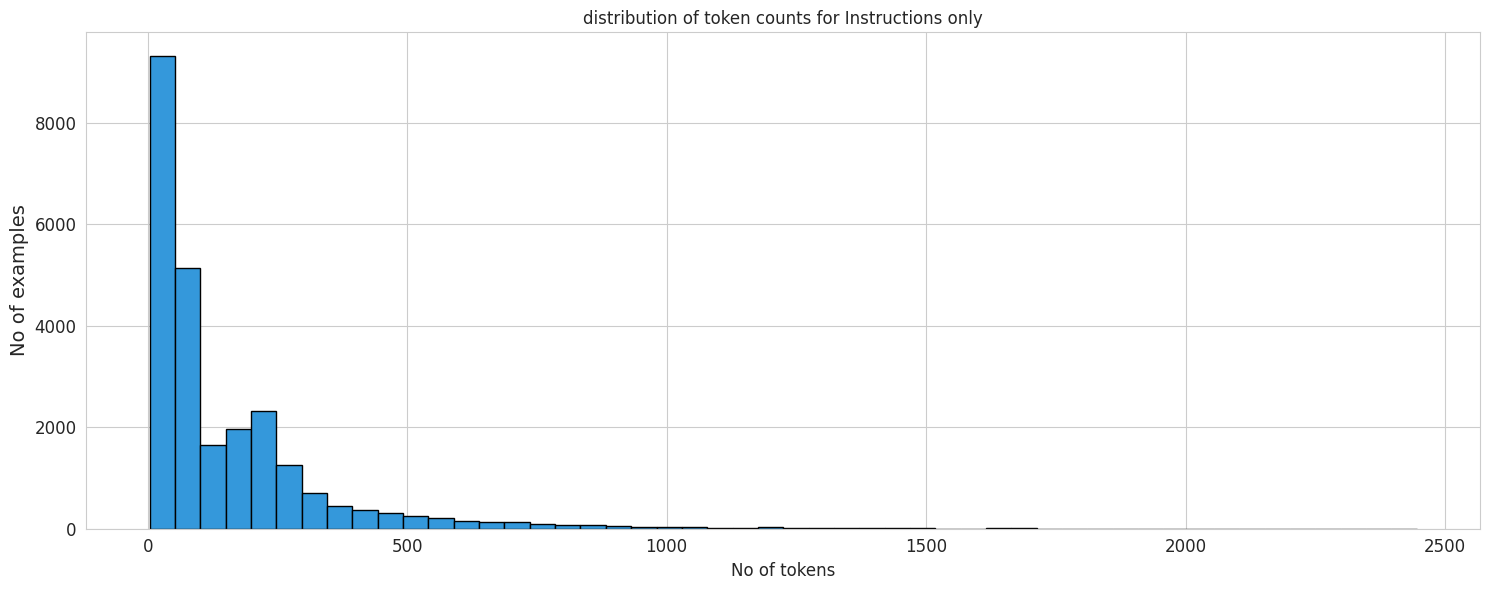

In [14]:
plot_distribution_tokens(instruction_token_counts,'distribution of token counts for Instructions only')

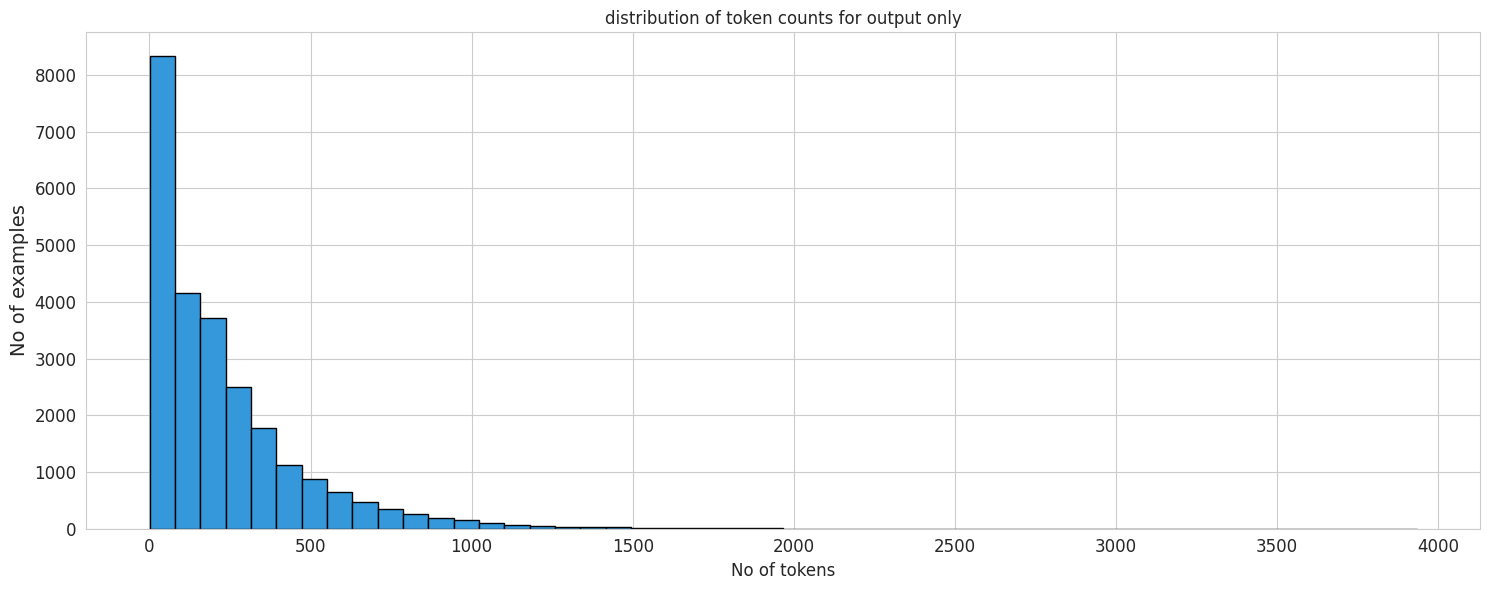

In [15]:
plot_distribution_tokens(output_token_counts,'distribution of token counts for output only')

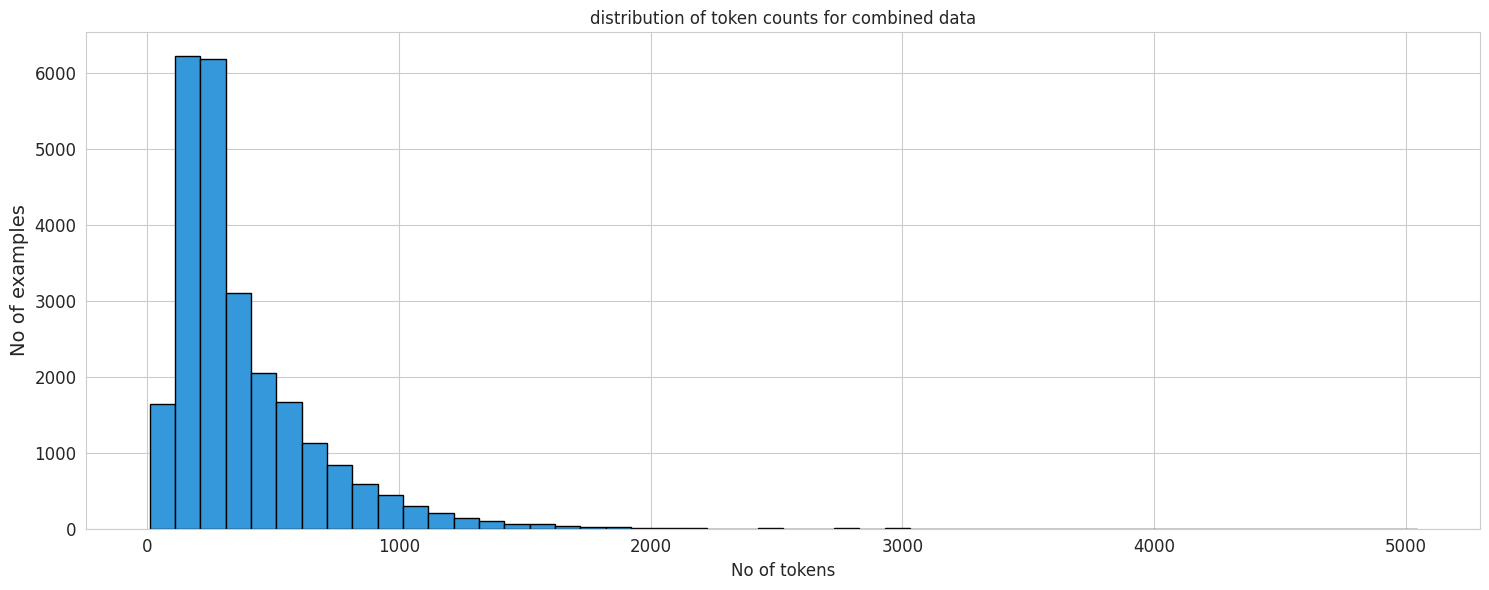

In [16]:
plot_distribution_tokens(combined_toke_counts,'distribution of token counts for combined data')

### max context size of llama-2 is 4096 so we will filter our token with 1800 tokens so that we will have tokens for prompt and output

24842
84


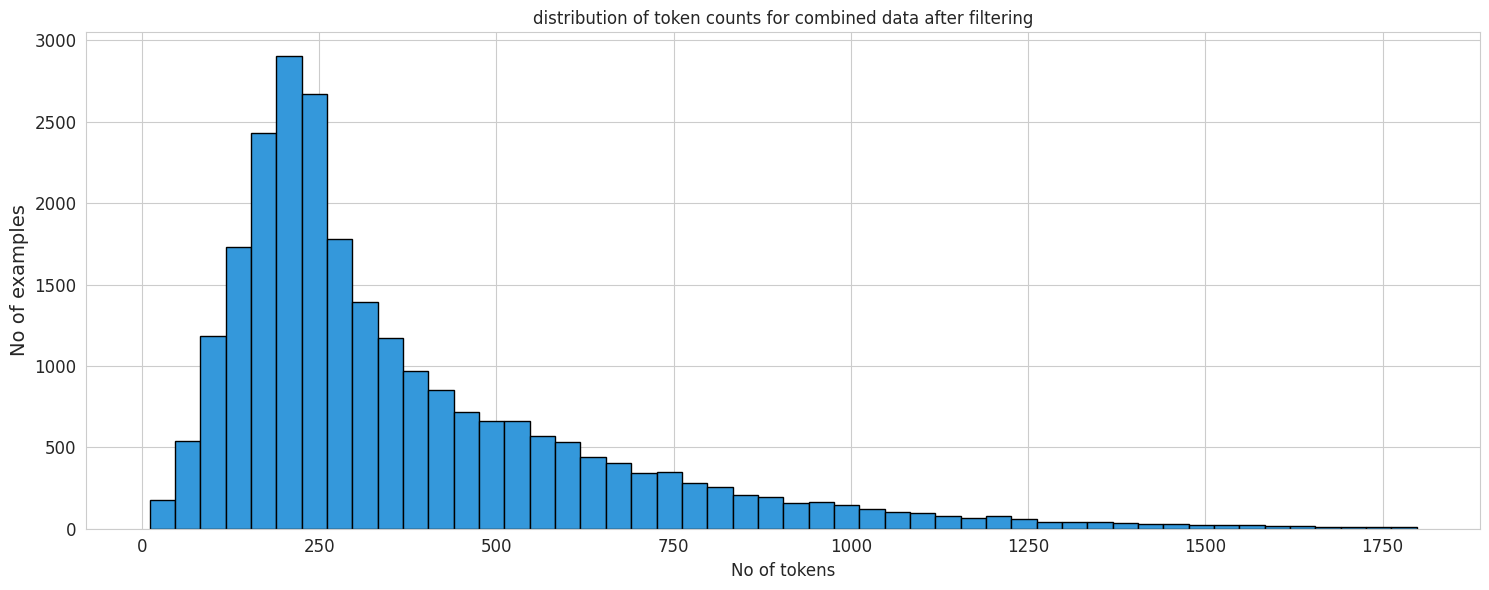

In [17]:
valid_indices = [i for i,count in enumerate(combined_toke_counts) if count <= 1800]
print(len(valid_indices))
print(len(datasets['train']) - len(valid_indices)) # we removed 84 records


datasets['train'] = datasets['train'].select(valid_indices)
token_counts = [combined_toke_counts[i] for i in valid_indices]

plot_distribution_tokens(token_counts,'distribution of token counts for combined data after filtering')

## To select the best embedding model we need to refer the MTEB leader board in huggingface
https://huggingface.co/spaces/mteb/leaderboard

In [18]:
def deduplicate_daatsets(dataset:Dataset, model:str, threshold= float):
  sentence_model = SentenceTransformer(model)
  outputs = [example['output'] for example in dataset['train']]
  print('converting text to embedidngs start...')
  embeddings = sentence_model.encode(outputs,show_progress_bar=True)
  dimension = embeddings.shape[1]
  index  = faiss.IndexFlatIP(dimension)
  normalized_embeddings = embeddings / np.linalg.norm(embeddings,axis=1,keepdims=True)
  index.add(normalized_embeddings)
  print('filtering out near-duplicates..')

  # D - distances, I - index
  D, I = index.search(normalized_embeddings, k=2) # return atmost 2 vectors
  to_kepp = []
  for i in tqdm(range(len(embeddings)),desc='Filtering'):
    if D[i,1] < threshold:
      to_kepp.append(i)
  dataset = dataset['train'].select(to_kepp)
  return DatasetDict({'train':dataset})

In [19]:
deduplicate_daatset = deduplicate_daatsets(datasets,'thenlper/gte-large',threshold=0.98)

converting text to embedidngs start...


Batches:   0%|          | 0/777 [00:00<?, ?it/s]

filtering out near-duplicates..


Filtering:   0%|          | 0/24842 [00:00<?, ?it/s]

In [20]:
print(len(datasets['train']))
print(len(deduplicate_daatset['train']))

print(len(datasets['train']) - len(deduplicate_daatset['train']))

24842
18885
5957


In [21]:
def get_top_k_rows(dataset,token_counts,k):
  sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i],reverse=True)
  top_k_indicies =  sorted_indices[:k]
  #top_k_indicies = sorted_indices[:min(k, len(token_counts))]
  print(len(top_k_indicies))

  top_k_data = {
      'instruction':[dataset['train'][i]['instruction'] for i in top_k_indicies],
      'output': [dataset['train'][i]['output'] for i in top_k_indicies]

  }


  return Dataset.from_dict(top_k_data)


instruction_token_counts = [len(tokenizer.tokenize(example['instruction'])) for example in datasets['train']]
output_token_counts = [len(tokenizer.tokenize(example['output']))for example in datasets['train']]
combined_toke_counts = [instruction + output for instruction,output in zip(instruction_token_counts,output_token_counts)]

get_datset = get_top_k_rows(datasets,combined_toke_counts,k=2000)

2000


In [22]:
get_datset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 2000
})

In [23]:
new_datset = DatasetDict({'train':get_datset})

In [24]:
new_datset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 2000
    })
})

In [25]:
def chat_template(example):
  example['instruction'] = f"### Instruction:/n{example['instruction']}\n\n### Response:\n"
  return example

In [26]:
new_datset1 = new_datset.map(chat_template)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
new_datset1

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 2000
    })
})

In [53]:
new_datset1['train'].to_pandas().head(2)

,instruction,output
0,### Instruction:/nwhich n <= 20 can be constru...,"[3, 4, 5, 6, 8, 10, 12, 15, 16, 17, 20]"
1,### Instruction:/nDevelop a C# application tha...,To create a simple ATM machine simulation in C...


In [28]:
from google.colab import userdata
hf_token = userdata.get('hugginface_token')

In [56]:
new_datset1.push_to_hub('mini-platypus',token = hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Finetuning llama-2 (1)SFT (2)RLHF

In [58]:
!pip install -q -U accelerate peft trl bitsandbytes wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [47]:
import os,torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)

from peft import LoraConfig,PeftModel,prepare_model_for_kbit_training
from trl import SFTTrainer

In [49]:
base_model = "NousResearch/Llama-2-7b-hf"
new_model = "llama-2-7b-finetuned-miniplatypus"

dataset = load_dataset("vedica1011/mini-platypus",split='train')

tokenizer = AutoTokenizer.from_pretrained(base_model,use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


In [50]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,


)

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj','down_proj','gate_proj','k_proj','q_proj','v_proj','o_proj']
    )

model = AutoModelForCausalLM.from_pretrained(base_model,
                                             quantization_config=bnb_config,
                                             device_map={"":0})
model = prepare_model_for_kbit_training(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [32]:
import accelerate

In [51]:
training_arguments = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    num_train_epochs=1,
    gradient_accumulation_steps=1,
    logging_steps=100,
    eval_steps=100,
    optim='paged_adamw_8bit',
    learning_rate=2e-4,
    save_steps=100,
    lr_scheduler_type='linear',
    report_to='wandb',
    max_steps=2
)

In [52]:
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    eval_dataset = dataset,
    peft_config = peft_config,
    tokenizer = tokenizer,
    args = training_arguments,
    dataset_text_field = 'instruction',
    max_seq_length=512,

)

In [53]:
trainer.train()
trainer.model.save_pretrained(new_model)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


OutOfMemoryError: ignored